Playing with data from [onset® HOBO® Occupancy/Light Data Loggers](https://www.onsetcomp.com/products/data-loggers/occupancy-light).  
In particular, this uses `.csv` files exported from [HOBOware](HOBOware).

In [1]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np

In [2]:
filepath = 'data/raw/datalogger_test.csv'
with open(filepath) as file:
#     reader = csv.DictReader(file)
#     data1 = [row for row in reader]
    data = pd.read_csv(file,header=1)  # ignore first line

In [4]:
data[:5]

,#,"Date Time, GMT-04:00","Light (LGR S/N: 10991767, SEN S/N: 10991767)","Occupancy (LGR S/N: 10991767, SEN S/N: 10991767)",Started (LGR S/N: 10991767),Internal Calibration (LGR S/N: 10991767),Button Up (LGR S/N: 10991767),Button Down (LGR S/N: 10991767),Stopped (LGR S/N: 10991767),End Of File (LGR S/N: 10991767)
0,1,10/05/18 07:53:09 PM,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN
1,2,10/05/18 07:53:10 PM,NaN,1.0,NaN,NaN,Logged,NaN,NaN,NaN
2,3,10/05/18 07:53:15 PM,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,10/05/18 07:53:19 PM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,10/05/18 07:53:24 PM,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


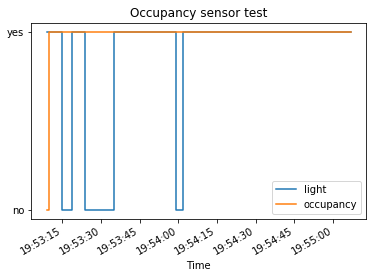

In [5]:
fig = plt.figure()
times = pd.to_datetime(data['Date Time, GMT-04:00'], format='%m/%d/%y %I:%M:%S %p')
light = ~data['Light (LGR S/N: 10991767, SEN S/N: 10991767)'].isnull()
occupancy = ~data['Occupancy (LGR S/N: 10991767, SEN S/N: 10991767)'].isnull()
plt.plot(
    times[light],
    data['Light (LGR S/N: 10991767, SEN S/N: 10991767)'][light],
    drawstyle='steps-post'  # https://stackoverflow.com/questions/35579480/how-to-plot-square-function-with-matplotlib#35579598
)
plt.plot(
    times[occupancy],
    data['Occupancy (LGR S/N: 10991767, SEN S/N: 10991767)'][occupancy],
    drawstyle='steps-post'
)
plt.title('Occupancy sensor test')
plt.yticks([0,1],['no','yes'])
# plt.ylabel('Value')
plt.xlabel('Time')
plt.legend(['light','occupancy'])
fig.autofmt_xdate()  # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib#23009503
fig.patch.set_facecolor('white')  # needed for dark theme https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color
# plt.show()

In [3]:
filepath = 'data/raw/motion-light data/ac206_2018-11-27.csv'

In [4]:
import os
import re
def strip_header_serial(fp):
    filename, ext = os.path.splitext(fp)
    new_filepath = filename+'_fixed'+ext
    HEADER_PATTERN = re.compile(r'"([^"()]+)( \([\w \d/:,]+\))?"')
    with open(fp) as infile:
        with open(new_filepath, 'w') as outfile:
            infile.readline()  # skip first line
            headers = HEADER_PATTERN.findall(infile.readline())
            headers = ['"'+h[0]+'"' for h in headers]  # remove serial number mentions
            outfile.writelines(','.join(headers) + '\n' + infile.read())
    return new_filepath

In [5]:
new_filepath = strip_header_serial(filepath)

In [6]:
with open(new_filepath) as file:
    data = pd.read_csv(file,header=0)

In [10]:
import pytz
data.index = pd.to_datetime(data['Date Time, GMT-04:00'], format='%m/%d/%y %I:%M:%S %p')
data.index = (data.index - pd.to_timedelta(4, 'h')).tz_localize(pytz.timezone('GMT')).tz_convert(pytz.timezone('US/Eastern'))  # https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
del data.index.name
del data['Date Time, GMT-04:00']

In [11]:
data[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File
2018-10-08 09:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN
2018-10-08 09:57:21-04:00,2,NaN,NaN,NaN,NaN,Logged,NaN,NaN,NaN
2018-10-08 09:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
max(data.index)

Timestamp('2018-11-27 19:45:01-0500', tz='US/Eastern')

In [13]:
min(data.index)

Timestamp('2018-10-08 13:57:20-0400', tz='US/Eastern')

In [14]:
min(data.index).dayofweek

0

In [15]:
light = data[~data['Light'].isnull()].copy()
occupancy = data[~data['Occupancy'].isnull()]

Let's get the length for each change in light value.

First I'll make sure that there aren't any repeated on/off entries

In [16]:
light[abs(light['Light'].diff()) != 1]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN
2018-11-27 19:45:01-05:00,4222,1.0,1.0,NaN,NaN,NaN,NaN,Logged,Logged


In [17]:
light[-1:]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File
2018-11-27 19:45:01-05:00,4222,1.0,1.0,NaN,NaN,NaN,NaN,Logged,Logged


Only the first and last entries don't differ from the previous entry (which is good).

In [18]:
light['delta'] = ser_diff = light.index.to_series().diff()  # calculate differences between times

In [19]:
light[:10]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,delta
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,NaT
2018-10-08 13:57:26-04:00,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:06
2018-10-08 13:57:30-04:00,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:04
2018-10-08 13:57:34-04:00,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:04
2018-10-08 13:57:38-04:00,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:04
2018-10-08 14:10:28-04:00,11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:12:50
2018-10-08 14:21:32-04:00,13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:11:04
2018-10-08 18:35:05-04:00,87,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04:13:33
2018-10-08 18:35:30-04:00,88,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:25
2018-10-08 20:25:28-04:00,124,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01:49:58


In [20]:
light['weekday'] = light.index.dayofweek

In [21]:
lights_on = light[light['Light'] > 0].groupby('weekday')['delta'].agg('sum')
lights_on

weekday
0   2 days 02:47:02
1   1 days 15:13:33
2   1 days 07:20:59
3   1 days 16:18:32
4   0 days 23:35:06
5   0 days 23:59:12
6   1 days 03:13:02
Name: delta, dtype: timedelta64[ns]

Text(0.5, 1.0, 'Hours of lights on in AC206 by day of week')

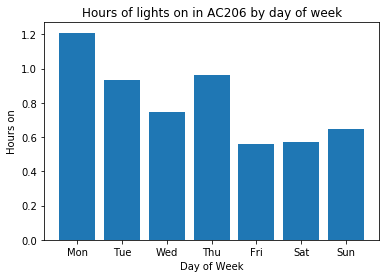

In [22]:
fig = plt.figure()
plt.bar(
    lights_on.index,
    lights_on / (6*7*np.timedelta64(1, 'h')),
)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Hours on')
plt.title('Hours of lights on in AC206 by day of week')

## Recalculating diffs

In [23]:
nlight = 

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,delta,weekday
2018-10-08 13:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,NaT,0
2018-10-08 13:57:26-04:00,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:06,0
2018-10-08 13:57:30-04:00,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:04,0
2018-10-08 13:57:34-04:00,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:04,0
2018-10-08 13:57:38-04:00,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:04,0
2018-10-08 14:10:28-04:00,11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:12:50,0
2018-10-08 14:21:32-04:00,13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:11:04,0
2018-10-08 18:35:05-04:00,87,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 04:13:33,0
2018-10-08 18:35:30-04:00,88,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:25,0
2018-10-08 20:25:28-04:00,124,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 01:49:58,0
